In [1]:
%matplotlib inline

In [3]:
import xarray as xr
from datatree import DataTree
from pathlib import Path
import pandas as pd
from dask.diagnostics import ProgressBar
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

import cartopy.crs as ccrs
import valenspy as vp
from valenspy import convert_kg_m2s_to_mm_day
from valenspy.diagnostic.visualizations import _add_features
from valenspy.diagnostic.functions import root_mean_square_error
from valenspy.input.unit_converter import CORDEX_VARIABLES


git_dir = Path(os.popen("git rev-parse --show-toplevel").read().strip())

User options

In [4]:
# Load data options
variables = ["tas", "pr", "tasmin", "tasmax"]
period = [1980, 2019]

# Plotting options - to be moved to a seperate "config" file
## Use the seaborn-v0_8-deep style?

mpl.rc('axes',edgecolor='grey')
mpl.rc('axes',labelcolor='dimgrey')
mpl.rc('axes',titlesize=14)
mpl.rc('axes',labelsize=10)
mpl.rc('axes', titlelocation="right")
mpl.rc('xtick',color='dimgrey')
mpl.rc('xtick',labelsize=10)
mpl.rc('ytick',color='dimgrey')
mpl.rc('ytick',labelsize=10)
mpl.rc('legend',fontsize='large')
mpl.rc('legend',frameon=False)
mpl.rc('text',color='dimgrey')
mpl.rc('figure', titlesize=16)


## Specify colors for the specific models
color_dict = {
    "/RCM/ERA5/ALARO1_SFX"          : "blue",
    "/RCM/ERA5/CCLM6-0-1-URB-ESG"   : "red",
    "/RCM/ERA5/MAR"                 : "green",
    "/obs/CLIMATE_GRID"             : "black"
}

d_cmap_diverging = { "tas": 'RdBu_r', "tasmax":'RdBu_r', "tasmin":'RdBu_r', "pr": 'BrBG' }
d_cmap_sequential = {"tas": 'YlOrRd', "tasmax": 'YlOrRd', "tasmin": 'YlOrRd', "pr": 'YlGnBu' }

#Diagnostic options
## Model2Self
do_AnnualCycle = {
    "compute": True,
    "variables" : variables,
}
do_TimeSeries = {
    "compute": True,
    "variables" : variables,
    "periods": [["1997-06-01", "1997-08-31"], ["2003-07-20", "2003-08-20"]]
}
do_TimeSeriesUkkel = {
    "compute": True,
    "variables" : variables,
    "periods": [["1997-06-01", "1997-08-31"]]
}
do_Trends = {
    "compute": False,
    "variables" : variables
}
do_SpatialMean = {
    "compute": True,
    "variables" : variables,
    "reference": "/obs/CLIMATE_GRID",
    "seasons" : ["All", "DJF", "MAM", "JJA", "SON"]
}

## Model2Ref
do_SpatialBias = {
    "compute": False,
    "variables" : variables,
    "reference": "/obs/CLIMATE_GRID",
    "seasons" : ["All" , "DJF", "MAM", "JJA", "SON"]
}

#Improve conversion of units handling
#Add xclim variables

: 

STEP 1: Load the data

In [5]:
manager = vp.InputManager(machine="hortense")

# ALARO (Using the catalog and the variables userinput)

df_alaro = pd.read_csv("/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/ValEnsPy/CORDEX_eval_scripts/catalog.csv")
df_alaro = df_alaro[df_alaro['frequency'] == 'day']
df_alaro = df_alaro[df_alaro['variable_id'].isin(variables)]
df_alaro

#Load all the paths in the df into one xarray dataset
ds_alaro = xr.open_mfdataset(df_alaro['path'].values, decode_coords='all', chunks="auto")
ds_alaro

## (Requires user adjustment)
# COSMO (Using the input manager - currently variables loaded manually)
experiment      = "CB2_CCLM_BEL28_ERA5_evaluation"
ds_cclm_tas     = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "mean"])
ds_cclm_tasmax  = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "max"]).rename({'tas':'tasmax'})
ds_cclm_tasmin  = manager.load_data("CCLM", ["tas"], freq="daily", path_identifiers=[experiment, "min"]).rename({'tas':'tasmin'})
ds_cclm_pr      = manager.load_data("CCLM", ["pr"], freq="daily", path_identifiers=[experiment, "sum"])
ds_cclm         = xr.merge([ds_cclm_tas, ds_cclm_pr, ds_cclm_tasmax, ds_cclm_tasmin])
del ds_cclm_tas , ds_cclm_pr, ds_cclm_tasmax, ds_cclm_tasmin
#ds_cclm = ds_cclm_tas

## (Requires user adjustment)
# MAR (Placeholder for MAR data - for plotting purposes)
ds_mar = ds_alaro

# Observational data
## CLIMATE_GRID (Regridded data)

ds_ref = manager.load_data("CLIMATE_GRID", variables, path_identifiers=["regridded"])

File paths found:
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_2010.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_2001.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_2000.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1994.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1987.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/daily/T_2M_daily_mean_1995.nc
/dodrio/scratch/projects/2022_200/project_output/rcs/CORDEXBE2/postprocessing/CB2_CCLM_BEL28_ERA5_evaluation/T_2M/dail

Create a DataTree object

In [9]:
## (Requires user adjustment)
data_dict = {
    "RCM/ERA5/ALARO1_SFX": ds_alaro,
    "RCM/ERA5/CCLM6-0-1-URB-ESG": ds_cclm,
    "RCM/ERA5/MAR": ds_mar,
    "obs/CLIMATE_GRID": ds_ref
}

dt = DataTree.from_dict(data_dict)

STEP 2: Preprocessing the data

In [7]:
# convert precipitation units from kg m-2 s-1 to mm day-1
def convert_kg_m2s_to_mm_day_ds(ds):
    ds=ds.copy()
    ds['pr'] = convert_kg_m2s_to_mm_day(ds['pr'])
    ds['pr'].attrs["units"] = "mm day$^{-1}$"
    return ds

In [10]:
#Regid to CLIMATE_GRID
dt["RCM"] = dt["RCM"].map_over_subtree(vp.remap_xesmf, dt.obs.CLIMATE_GRID.to_dataset(), method="conservative", regridding_kwargs={"keep_attrs": True})

#Select the time period from period[0] to period[1] (inclusive)
dt = dt.sel(time=slice(f"{period[0]}-01-01", f"{period[1]}-12-31"))

dt = dt.map_over_subtree(convert_kg_m2s_to_mm_day_ds)

STEP 3: Diagnostics

In [11]:
from valenspy.diagnostic import AnnualCycle
from valenspy.diagnostic import TimeSeriesSpatialMean
from valenspy.diagnostic import TimeSeriesTrendSpatialMean
from valenspy.diagnostic import SpatialTimeMean
from valenspy.diagnostic import SpatialBias

Model2Self

Annual Cycle

[########################################] | 100% Completed | 252.16 s
[########################################] | 100% Completed | 60.05 s
[########################################] | 100% Completed | 253.53 s
[########################################] | 100% Completed | 23.51 s


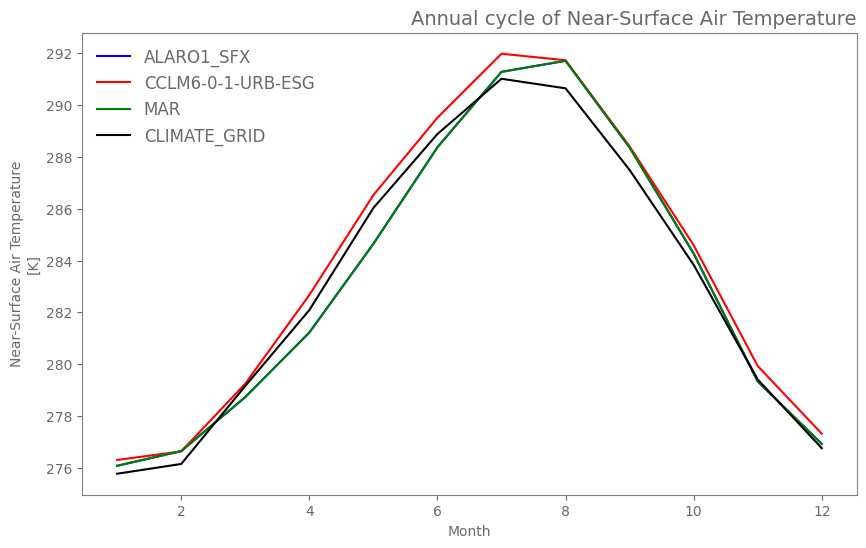

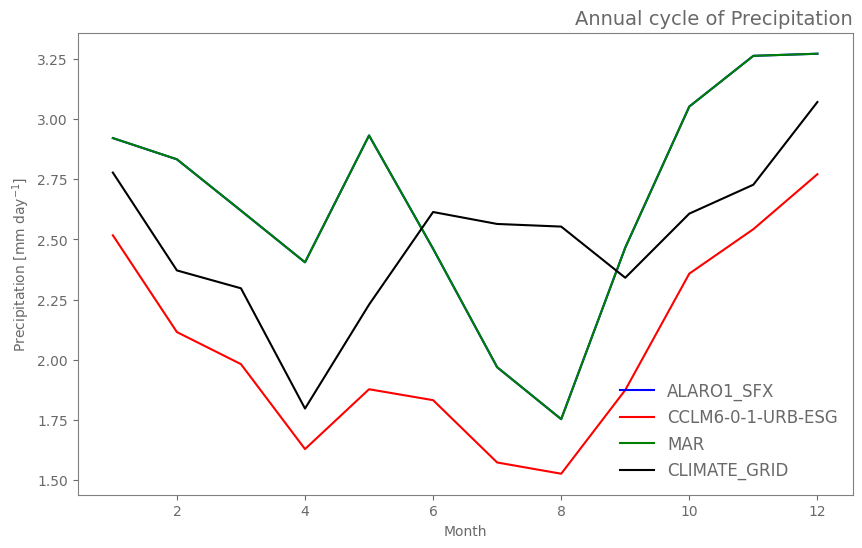

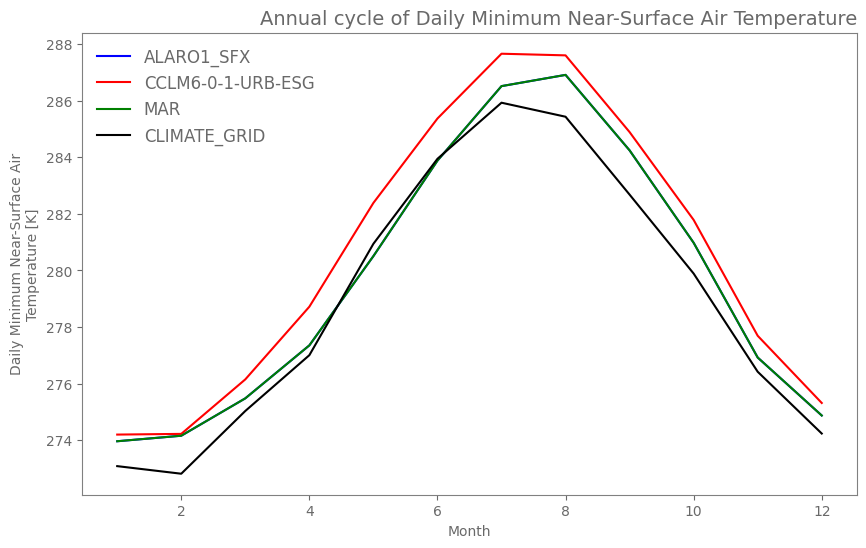

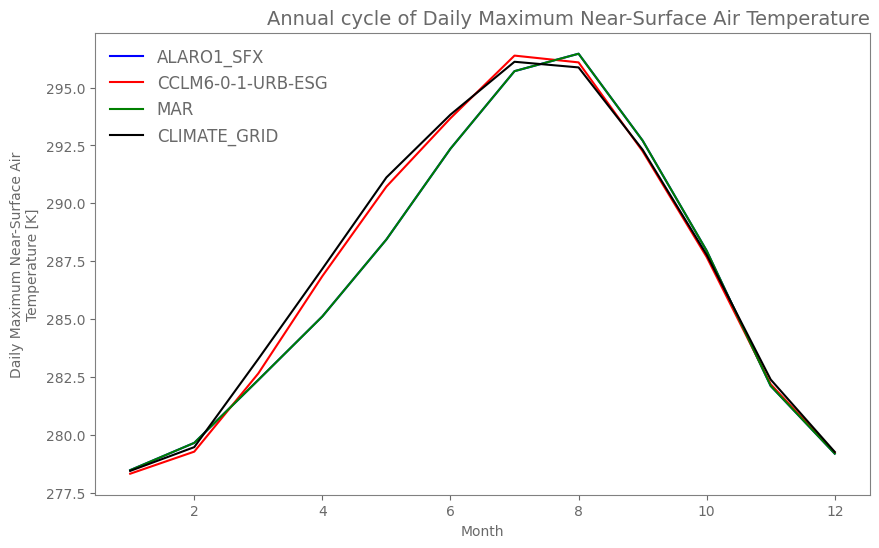

In [12]:
if do_AnnualCycle["compute"]:
    with ProgressBar():
        dt_annual_cycle = AnnualCycle(dt).compute()

    for var in do_AnnualCycle["variables"]:
        fig, ax = plt.subplots(figsize=(10, 6))
        AnnualCycle.plot_dt(dt_annual_cycle, var=var, ax=ax, label="name", colors=color_dict)
        plt.title(f"Annual cycle of {CORDEX_VARIABLES[var]['long_name']}")
        plt.legend()
        plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/{var}_bel_mean_annual_cycle.png")

TimeSeries

[########################################] | 100% Completed | 30.58 s
[########################################] | 100% Completed | 9.23 sms
[########################################] | 100% Completed | 33.06 s
[########################################] | 100% Completed | 4.28 ss
[########################################] | 100% Completed | 985.30 ms
[########################################] | 100% Completed | 304.51 ms
[########################################] | 100% Completed | 307.45 ms
[########################################] | 100% Completed | 1.23 sms


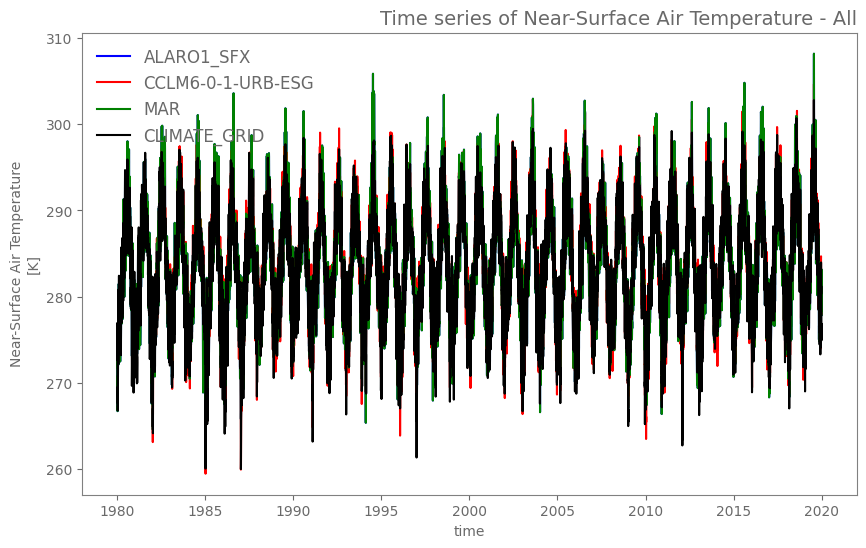

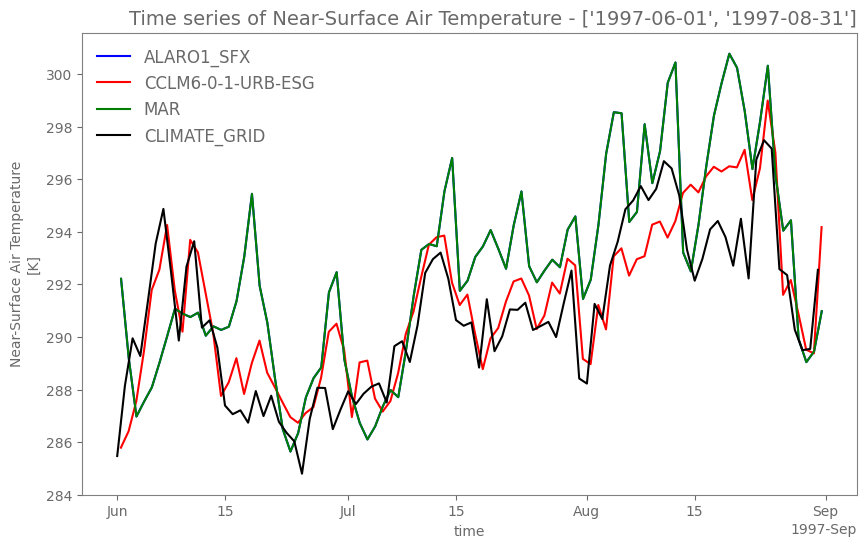

In [47]:
if do_TimeSeries["compute"]:
    for period in do_TimeSeries["periods"]:
        if period == "All":
            dt_time_series = dt
        else:
            dt_time_series = dt.sel(time=slice(period[0], period[1]))
        with ProgressBar():
            dt_time_series = TimeSeriesSpatialMean(dt_time_series).compute()

        for var in do_TimeSeries["variables"]:
            fig, ax = plt.subplots(figsize=(15, 5))
            TimeSeriesSpatialMean.plot_dt(dt_time_series, var=var, ax=ax, label="name", colors=color_dict)
            plt.title(f"Time series of {CORDEX_VARIABLES[var]['long_name']}")
            plt.legend()
            plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/{var}_time_series_bel_mean_{period}.png")

TimeSeries (Ukkel)

[########################################] | 100% Completed | 31.90 s
[########################################] | 100% Completed | 9.21 ss
[########################################] | 100% Completed | 29.70 s
[########################################] | 100% Completed | 1.04 sms
[########################################] | 100% Completed | 28.21 s
[########################################] | 100% Completed | 9.12 sms
[########################################] | 100% Completed | 31.51 s
[########################################] | 100% Completed | 1.22 sms


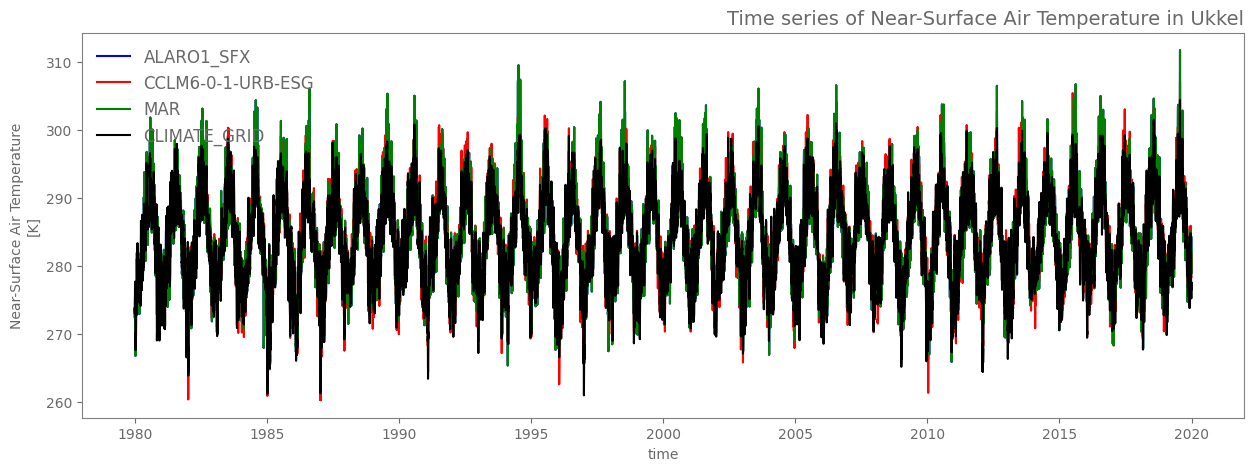

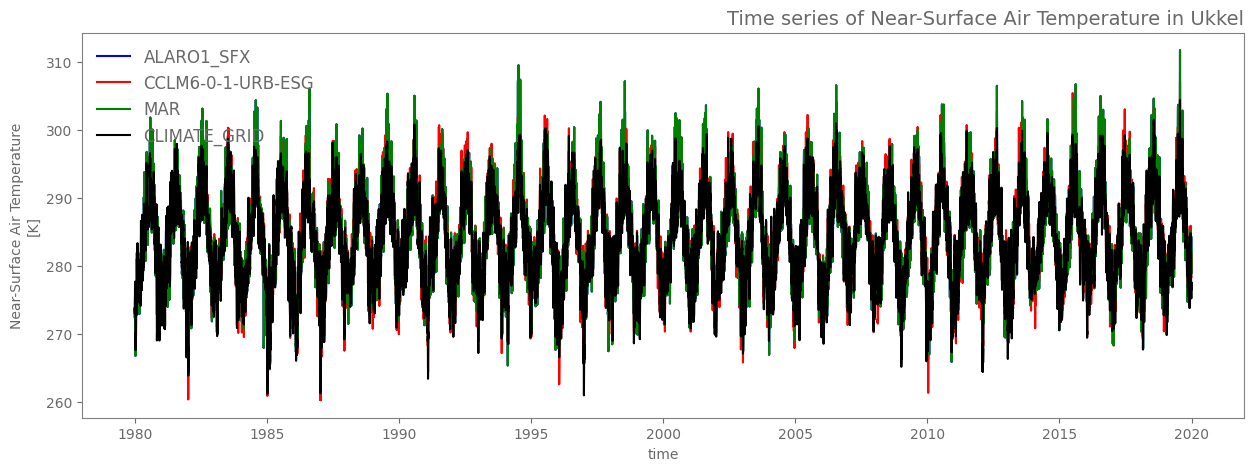

In [50]:
if do_TimeSeriesUkkel["compute"]:
    Ukkel = (4.37, 50.79)
    dt_ukkel_hw = dt.map_over_subtree(vp.select_point, Ukkel[0], Ukkel[1])
    for period in do_TimeSeries["periods"]:
        if period == "All":
            dt_time_series = dt_ukkel_hw
        else:
            dt_time_series_uccle = dt_ukkel_hw.sel(time=slice(period[0], period[1]))
        
        with ProgressBar():
            print(f"Computing time series for {period}")
            dt_time_series_uccle = TimeSeriesSpatialMean(dt_time_series).compute()

        for var in do_TimeSeries["variables"]:
            fig, ax = plt.subplots(figsize=(15, 5))
            TimeSeriesSpatialMean.plot_dt(dt_time_series_uccle, var=var, ax=ax, label="name", colors=color_dict)
            plt.title(f"Time series of {CORDEX_VARIABLES[var]['long_name']} in Ukkel")
            plt.legend()
            plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/{var}_time_series_ukkel_{period}.png")

Trends

[########################################] | 100% Completed | 30.67 s
[########################################] | 100% Completed | 10.65 s
[########################################] | 100% Completed | 30.20 s
[########################################] | 100% Completed | 1.01 sms


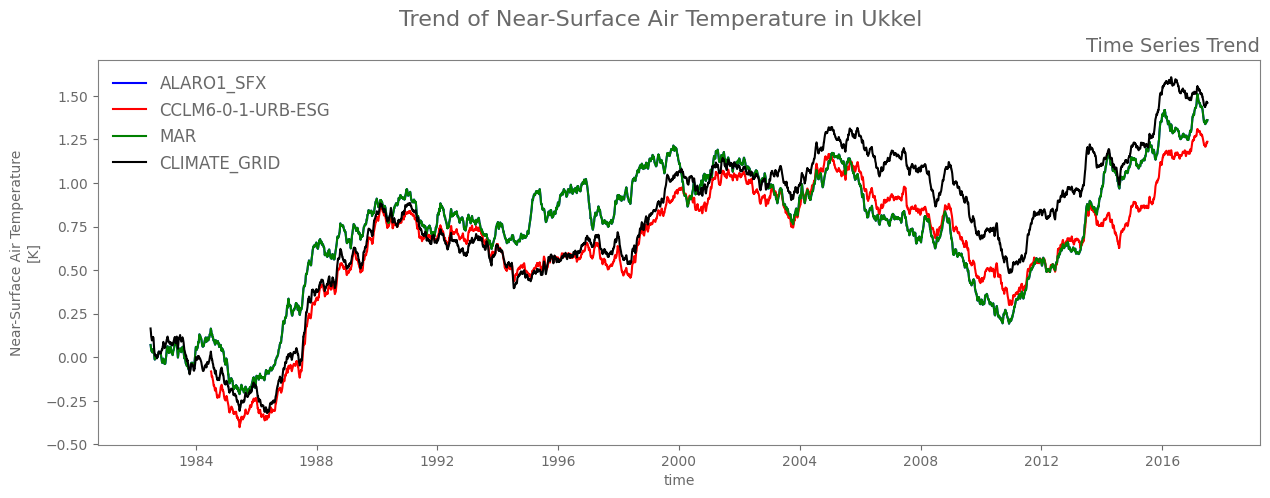

In [56]:
if do_Trends["compute"]:
    years=5
    window_size = 366*years # 5 years
    Ukkel = (4.37, 50.79)
    dt_Ukkel = dt.map_over_subtree(vp.select_point, Ukkel[0], Ukkel[1])
    dt_Ukkel = dt_Ukkel - dt_Ukkel.sel(time=slice("1980-01-01", "1985-12-31")).mean("time")
    with ProgressBar():
        dt_trends = TimeSeriesTrendSpatialMean(dt_Ukkel, window_size=window_size).compute()

    for var in do_Trends["variables"]:
        fig, ax = plt.subplots(figsize=(15, 5))
        TimeSeriesTrendSpatialMean.plot_dt(dt_trends, var=var, ax=ax, label="name", colors=color_dict)
        plt.legend()
        plt.title(f"Trend of {CORDEX_VARIABLES[var]['long_name']} in Ukkel")
        plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/{var}_trend_ukkel_window_{years}y.png")

Spatial Mean

Computing spatial mean for DJF
[########################################] | 100% Completed | 31.27 s
[########################################] | 100% Completed | 11.13 s
[########################################] | 100% Completed | 33.63 s
[########################################] | 100% Completed | 4.98 ss


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_en

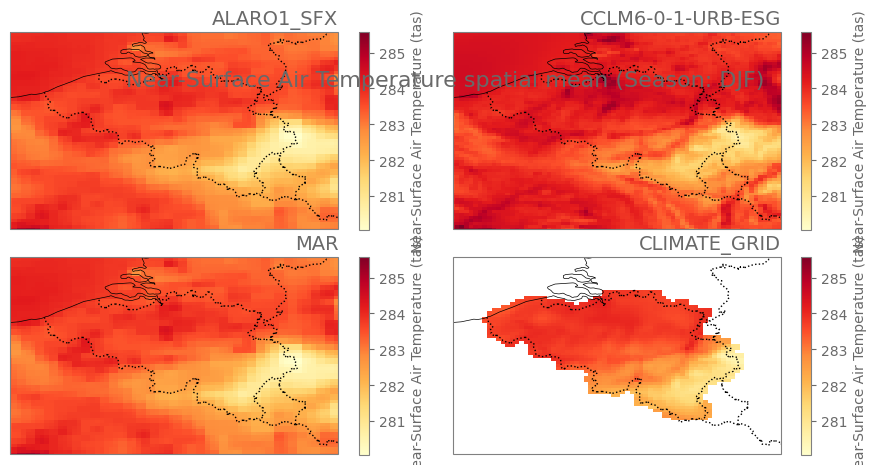

In [54]:
if do_SpatialMean["compute"]:
    #Add other processing steps here (e.g. period selection)
    for season in do_SpatialMean["seasons"]:
        #Select season
        if season != "All":
            dt_s = dt.map_over_subtree(lambda x: x.sel(time=x.time.dt.season == season))
        else:
            dt_s = dt
        #Compute
        with ProgressBar():
            print(f"Computing spatial mean for {season}")
            dt_spatial_mean = SpatialTimeMean(dt_s).compute()

        #Plot
        for var in do_SpatialMean["variables"]:
            fig, axes = plt.subplots(2, 2, figsize=(9, 5), subplot_kw={"projection": ccrs.PlateCarree()})
            axes = axes.flatten()
            
            SpatialTimeMean.plot_type = "facetted"

            SpatialTimeMean.plot_dt(dt_spatial_mean, var=var, axes=axes,shared_cbar="min_max", label="name", cmap=d_cmap_sequential[var])

            for ax in axes:
                _add_features(ax, region='belgium')
            
            fig.suptitle(f'{CORDEX_VARIABLES[var]["long_name"]} spatial mean (Season: {season})')
            fig.tight_layout()
            plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/{var}_spatial_mean_{season}.png")

Model2Ref

SpatialBias

Computing spatial bias for season All
[########################################] | 100% Completed | 40.51 s
[########################################] | 100% Completed | 14.92 s
[########################################] | 100% Completed | 37.95 s


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Computing spatial bias for season DJF
[########################################] | 100% Completed | 24.17 s
[########################################] | 100% Completed | 15.20 s
[########################################] | 100% Completed | 29.63 s


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Computing spatial bias for season MAM
[########################################] | 100% Completed | 27.76 s
[########################################] | 100% Completed | 12.97 s
[########################################] | 100% Completed | 29.84 s


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Computing spatial bias for season JJA
[########################################] | 100% Completed | 24.25 s
[########################################] | 100% Completed | 18.59 s
[########################################] | 100% Completed | 25.67 s


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


Computing spatial bias for season SON
[########################################] | 100% Completed | 25.32 s
[########################################] | 100% Completed | 14.98 s
[########################################] | 100% Completed | 23.60 s


/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '
/dodrio/scratch/projects/2022_200/project_output/RMIB-UGent/vsc46032_kobe/conda_envs/valenspy_xesmf/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


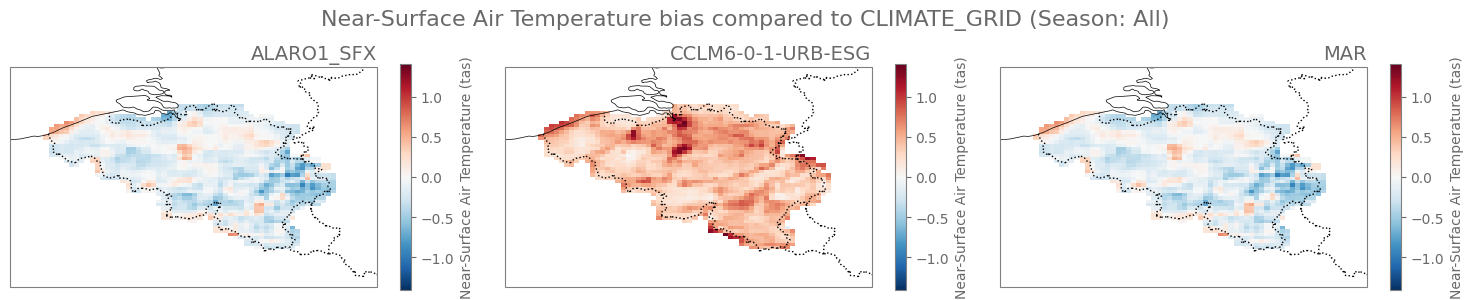

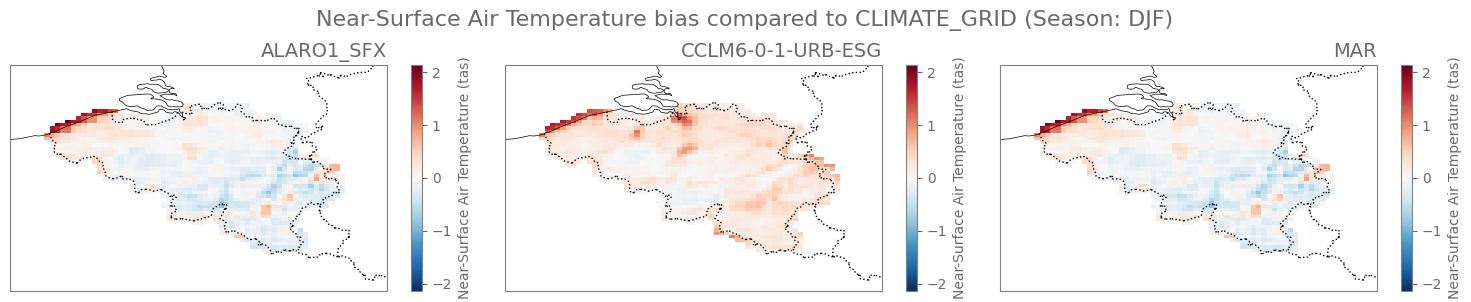

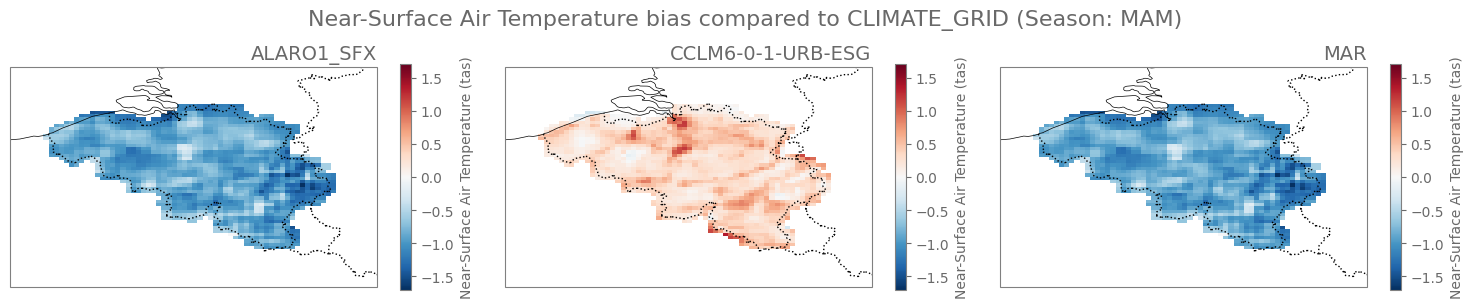

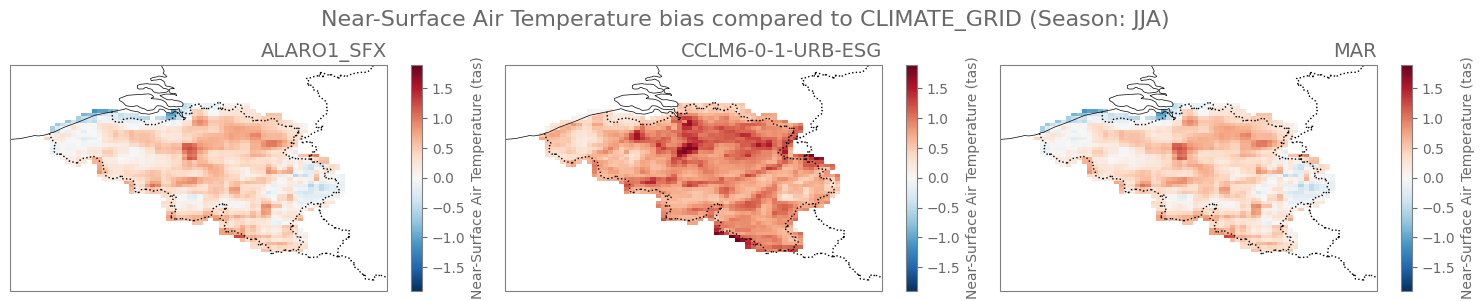

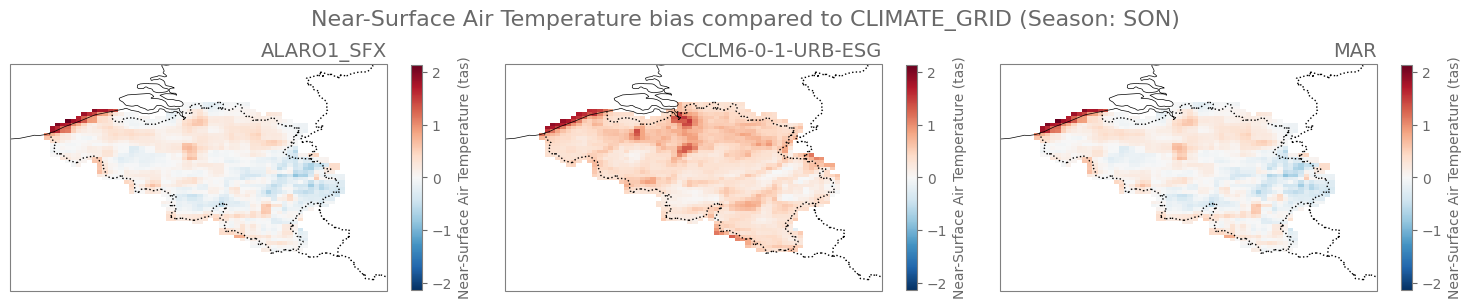

In [37]:
if do_SpatialBias["compute"]:
    for season in do_SpatialBias["seasons"]:
        if season != "All":
            dt_s = dt.map_over_subtree(lambda x: x.sel(time=x.time.dt.season == season))
        else:
            dt_s = dt

        #Compute    
        with ProgressBar():
            print(f"Computing spatial bias for season {season}")
            ds_ref = dt_s[do_SpatialBias["reference"]].to_dataset()
            dt_spatial_bias = SpatialBias(dt_s.RCM, ref=ds_ref).compute()

        #Plot
        for var in do_SpatialBias["variables"]:
            fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={"projection": ccrs.PlateCarree()})
            axes = axes.flatten()
            cbar_kwargs={"shrink": 0.52}

            SpatialBias.plot_dt(dt_spatial_bias, var=var, axes=axes, shared_cbar="abs", label="name", cbar_kwargs=cbar_kwargs, cmap=d_cmap_diverging[var])
            
            for ax in axes:
                _add_features(ax, region='belgium')

            fig.suptitle(f'{CORDEX_VARIABLES[var]["long_name"]} bias compared to CLIMATE_GRID (Season: {season})', y=0.8)
            fig.tight_layout()
            plt.savefig(git_dir / f"CORDEX_eval_scripts/plots/{var}_spatialbias_{season}.png")